In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from src.text_preprocessor import TextPreprocessor
from src.text_vectorizer import TextVectorizer
from src.classifier_model import LSTMClassifierModel

from src.eval_utils import evaluate_multi_classif, explain_observation, export_all
from src.plot_utils import plot_categories, plot_w2v

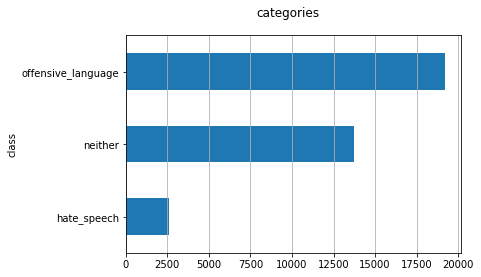

In [2]:
 # load data
df1 = pd.read_csv('../data/t_davidson_hate_speech_and_offensive_language.csv', index_col=0)
df2 = pd.read_csv('../data/vicomtech_hate_speech_dataset.csv', index_col=0)
df = df1.append(df2, ignore_index=True)
plot_categories(df)

sentences = df['tweet']
mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
y = df[['class']]
y = y.replace({'class': mapping})['class']

In [3]:
# split into train and test (the val set will be taken from `sentences_train` during training)
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.1, random_state=1000)

In [4]:
# initialize sklearn preprocessing pipeline
nltk_stop_words = pd.read_csv('../data/nltk_stop_words.csv', header=None).iloc[0].tolist()
custom_stop_words = pd.read_csv('../data/custom_stop_words.csv', header=None).iloc[0].tolist()
preprocess_pipeline = Pipeline(steps=[
    ('normalize', TextPreprocessor(custom_stop_words=nltk_stop_words + custom_stop_words)),
    ('features', TextVectorizer(enable_plots=True)),
])

# initialize sklearn classifier pipeline
classifier_pipeline = Pipeline(steps=[
    ('preprocessing', preprocess_pipeline),
    ('classifier', LSTMClassifierModel(encode_y=True, epochs=75, batch_size=512))
])

In [5]:
print(preprocess_pipeline['normalize'].nlp.Defaults.stop_words)

{'empty', 'both', 'take', 'wherein', 'beyond', 'whence', 'wherever', 'been', 'than', 'them', 'have', 'unless', 'a', 'just', 'whereupon', 'once', 'fifty', 'n’t', 'anyone', 'twenty', 'some', 'much', 'not', 'becomes', 'mine', 'somewhere', 'may', '‘s', 'hundred', 'move', 'five', 'above', 'that', 'throughout', 'if', 'where', 'same', 'already', 'having', 'always', 'being', 'few', 'ours', 'afterwards', 'front', 'who', "'m", 'ourselves', 'did', 'so', 'other', 'therein', 'third', 'na', 'say', 'except', 'after', 'does', 'really', 'but', 'then', 'no', 'yours', 'beforehand', 'had', 'though', 'whom', 'yourselves', 'either', 'between', 'an', 'alone', 'everyone', 'various', 'together', 'still', 'might', 'upon', 'whereas', 'made', 'whatever', 'she', 'herself', 'anywhere', 'put', 'against', 'mostly', 'those', 't', 'thence', 'about', 'nothing', 'also', 'often', 'noone', 'name', 'of', 'became', 'seems', 'whole', 'along', 'among', 'anyhow', '‘re', 'formerly', 'last', 'give', 'up', 'eight', 'done', '‘d', '

../src/text_vectorizer.py:141: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=self.df_ngrams.groupby('ngrams')['ngrams', 'freq', 'word'].head(10))


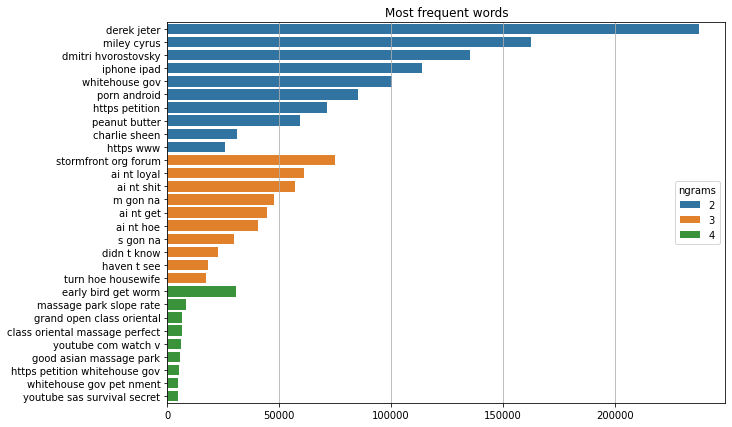

--- tokenization ---
21987 words
--- padding to sequence ---
32003 sequences of length 15


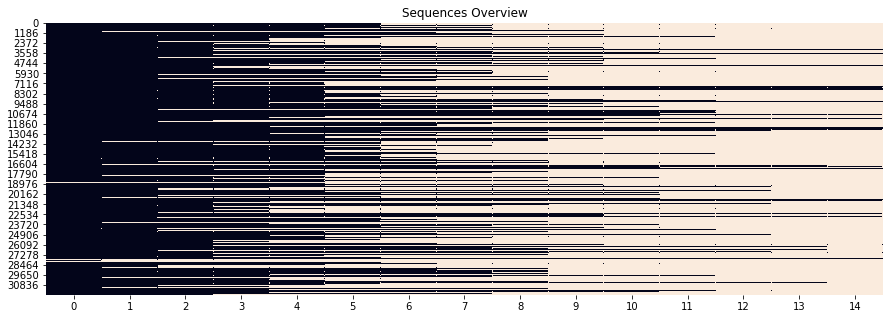

vocabulary mapped to 21988 vectors of size 300
{0: 'hate_speech', 1: 'neither', 2: 'offensive_language'}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      6596400     input_1[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, 15, 300)      0           embedding[0][0]                  
                                                                 embedding[0][0]                  
________________________________________________________________________________________

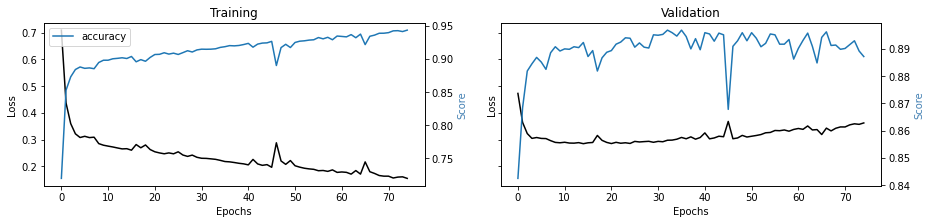

In [6]:
# train model
classifier_pipeline.fit(sentences_train, y_train)
plt.show()

In [7]:
# plot word clouds
# nlp = classifier_pipeline['preprocessing']['features'].nlp
# plot_w2v(lst_words=['trash'], nlp=nlp, plot_type="3d", top=20, annotate=True, figsize=(20, 5))

In [8]:
# plot_w2v(lst_words=None, nlp=nlp.wv, plot_type="2d", annotate=False, figsize=(20, 5))

../src/text_vectorizer.py:141: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=self.df_ngrams.groupby('ngrams')['ngrams', 'freq', 'word'].head(10))


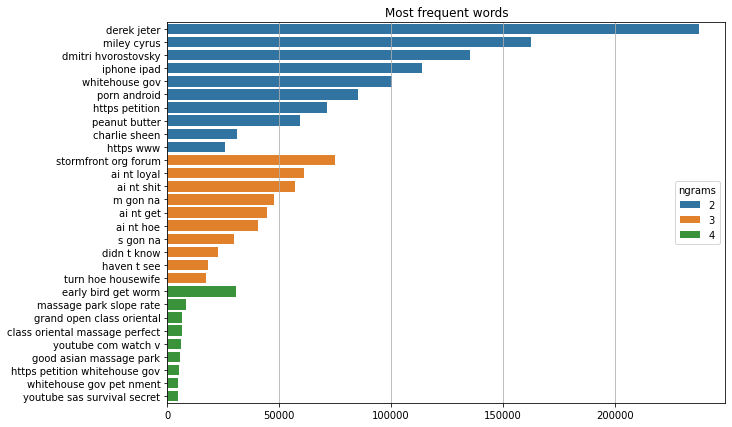

--- tokenization ---
21987 words
--- padding to sequence ---
3556 sequences of length 15


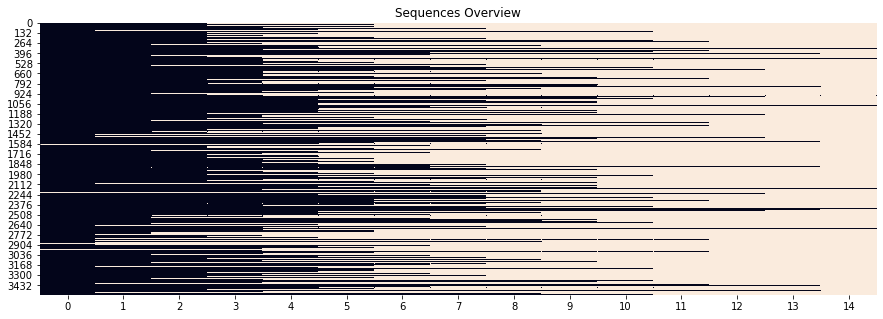

vocabulary mapped to 21988 vectors of size 300


In [9]:
# preprocess test vector
X_test, _ = preprocess_pipeline.fit_transform(sentences_test)

In [10]:
# run inference
predicted_prob, predicted = classifier_pipeline['classifier'].predict(X_test)

Accuracy: 0.88
Auc: 0.92
Detail:
                    precision    recall  f1-score   support

       hate_speech       0.31      0.26      0.28       218
           neither       0.88      0.92      0.90      1410
offensive_language       0.94      0.93      0.93      1928

          accuracy                           0.88      3556
         macro avg       0.71      0.70      0.71      3556
      weighted avg       0.88      0.88      0.88      3556



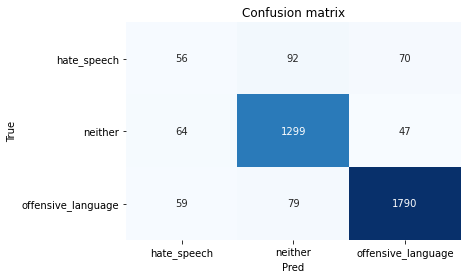

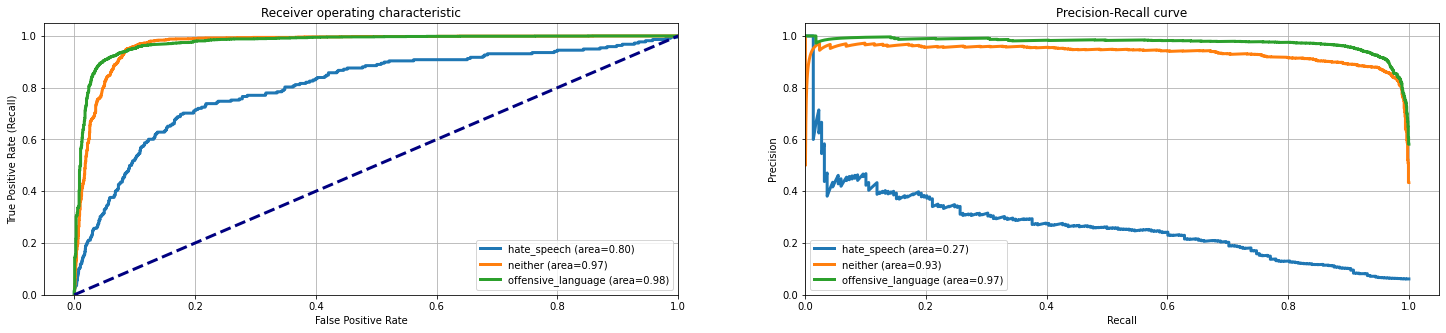

In [11]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(25, 5))

@JRise88 do it then pussy
True: offensive_language --> Pred: offensive_language | Prob: 1.0


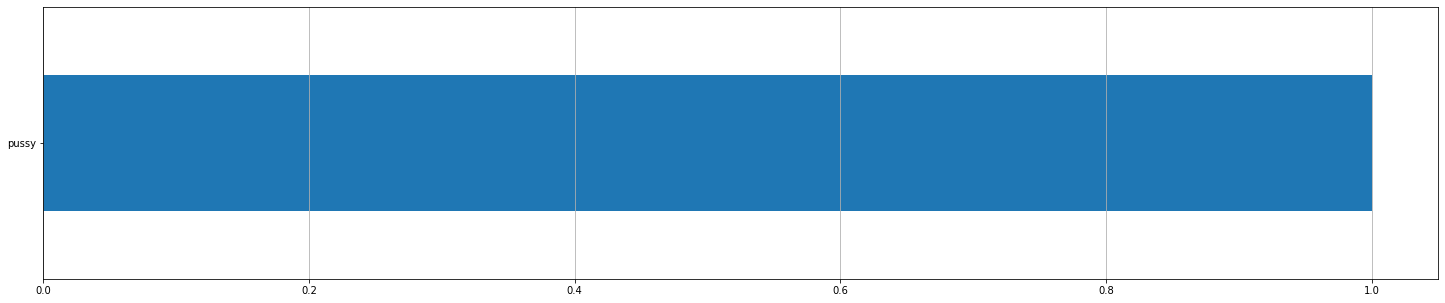

In [12]:
i = np.random.randint(0, len(sentences_test))
print(sentences_test.iloc[i])
cleaned_text = preprocess_pipeline['normalize'].transform(sentences_test.iloc[[i]]).iloc[0]
observation_dict = {
    'text': cleaned_text,
    'label': y_test.iloc[i],
    'predicted': predicted[i],
    'prediction_prob': predicted_prob[i]
}

nlp_dict = {
    'bigrams_detector': preprocess_pipeline['features'].ngrams_detector_list[0],
    'trigrams_detector': preprocess_pipeline['features'].ngrams_detector_list[1],
    'tokenizer': preprocess_pipeline['features'].fitted_tokenizer,
    'model': classifier_pipeline['classifier'].model
}

html_text = explain_observation(observation_dict, nlp_dict, top=10)

In [13]:
# export model and auxiliary info
export_all(classifier_pipeline['classifier'], preprocess_pipeline['features'], folder_out_path='/home/cluster1/Documents/hate_speech_classifier/saved_model/hate_classifier_v4')